In [20]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import cairosvg
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [21]:
def unique(list1):
    '''return only the unique elements of a list (no duplicates)'''
    x = np.array(list1)
    unique_list = np.unique(x).tolist()
    return unique_list

In [ ]:
output_dir = Path("TelogatorOutputs/CustomThresholdOuts")
analysis_dir = output_dir.parent.parent / 'AnalysisAndFigures-Final'
figure_dir = analysis_dir / 'Bulk_TL_Plots'
if not os.path.isdir(analysis_dir):
    os.mkdir(analysis_dir)
if not os.path.isdir(figure_dir):
    os.mkdir(figure_dir)

all_files = [x for x in os.listdir(output_dir) if "TB-" in x]
patient_key = pd.read_excel("PatientKey.xlsx")

In [24]:
prefix_dict = {"PBA54105":2,"PBA40353":1,"PBC41886":1}
all_df = []
for file in all_files:
    sample_df = pd.read_csv(output_dir/file/'tlens_by_allele.tsv',delimiter='\t').reset_index(drop=True)
    ind = patient_key[patient_key['Sample']==file].index.tolist()[0]
    sample_info_dict = patient_key.iloc[ind].to_dict()
    tel_len = [j for i in sample_df['read_TLs'].apply(lambda x: [int(y) for y in x.split(',')]).tolist() for j in i]
    adj_tel_len = [j for i in sample_df.apply(lambda x: [int(y)+x['tvr_len'] for y in x['read_TLs'].split(',')],axis=1).tolist() for j in i]
    seq_prefix = [j for i in sample_df.supporting_reads.apply(lambda x: [y.split('-')[0] for y in x.split(',')]).tolist() for j in i]
    read_id = [j for i in sample_df.supporting_reads.apply(lambda x: [y for y in x.split(',')]).tolist() for j in i]
    if not len(tel_len)==len(adj_tel_len)==len(seq_prefix):
        print(f'Error separating individual reads for sample {file}!')
    sample = [file]*len(tel_len)
    figure_name = [sample_info_dict['FigureName']]*len(tel_len)
    figure_order = [sample_info_dict['FigureOrder']]*len(tel_len)
    family = [sample_info_dict['Patient#']]*len(tel_len)
    tdf = pd.DataFrame()
    tdf['sample'] = sample
    tdf['tel_len'] = tel_len
    tdf['adj_tel_len'] = adj_tel_len
    tdf['seq_prefix'] = seq_prefix
    tdf['read_id'] = read_id
    tdf['seq_round'] = tdf.seq_prefix.apply(lambda x: prefix_dict[x])
    tdf['figure_name'] = figure_name
    tdf['figure_order'] = figure_order
    tdf['family'] = family
    all_df.append(tdf.copy())

bulk_length_df = pd.concat(all_df)
bulk_length_df = bulk_length_df.sort_values(by="figure_order").reset_index(drop=True).copy()

bulk_length_df.to_csv(analysis_dir/'1_Bulk_Telomere_Lengths.csv',index=False)

In [ ]:
tel_reads_dict = {}
bulk_length_df['plot_name'] = ''
for sample in unique(bulk_length_df['sample'].tolist()):
    num_reads = len(bulk_length_df[bulk_length_df['sample']==sample])
    inds = bulk_length_df[bulk_length_df['sample']==sample].index

    bulk_length_df.loc[inds,'plot_name'] = f'\n({num_reads})'
    tel_reads_dict[sample] = num_reads

bulk_length_df['plot_name'] = bulk_length_df['figure_name']+bulk_length_df['plot_name']
bulk_length_df.to_csv(figure_dir/'Bulk_Telomere_Length_Measurements.csv',index=False)

In [26]:
# get telomere read enrichment stats
enrichment_stats = []
for file in all_files:
    with open(output_dir/'logs'/f'{file}.out','r') as f:
        log_stats = f.readlines()
    total_reads = int(log_stats[3].split(' ')[2])
    total_telomeric = tel_reads_dict[file]
    pct_tel = total_telomeric/total_reads*100
    plot_name = patient_key[patient_key['Sample']==file]['FigureName'].item()
    med_tl = bulk_length_df[bulk_length_df['sample']==file]['adj_tel_len'].median()
    enrichment_stats.append([plot_name,file,total_reads,total_telomeric,pct_tel,med_tl])

enrichment_stats = pd.DataFrame(data=enrichment_stats,columns=['SampleName','Sample','TotalReads','TelomericReads','%Telomeric','Median_Adj_Tel_Len'])
enrichment_stats.to_csv(analysis_dir/'1a_Telomere_Reads_By_Sample.csv',index=False)

In [ ]:
long_tel_statistics = pd.DataFrame(columns = ['median','<=10kb',">10kb",'figure_name','figure_order'])
for patient in unique(bulk_length_df['sample'].tolist()):
    subset_df = bulk_length_df[bulk_length_df['sample']==patient]
    long = sum(subset_df.adj_tel_len>10000)
    long_tel_statistics.loc[patient,"median"] = subset_df.adj_tel_len.median()
    long_tel_statistics.loc[patient,">10kb"] = long
    short = sum(subset_df.adj_tel_len<=10000)
    long_tel_statistics.loc[patient,"<=10kb"] = short
    long_tel_statistics.loc[patient,'figure_name'] = patient_key[patient_key['Sample']==patient]['FigureName'].item()
    long_tel_statistics.loc[patient,'figure_order'] = patient_key[patient_key['Sample']==patient]['FigureOrder'].item()
long_tel_statistics=long_tel_statistics.sort_values(by='figure_order')
ctrl_sample = 'TB-18-03026'
ctrl_values = [long_tel_statistics.loc[ctrl_sample,'<=10kb'],long_tel_statistics.loc[ctrl_sample,">10kb"]]
long_tel_statistics[['odds_ratio','p_value']] = long_tel_statistics.apply(lambda x: stats.fisher_exact([ctrl_values,[x['<=10kb'],x['>10kb']]],'greater'),axis=1).tolist()
pvals = long_tel_statistics.p_value.tolist()
rejected, q_values, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
long_tel_statistics['q_value'] = q_values
long_tel_statistics['rejected'] = rejected
long_tel_statistics
long_tel_statistics.to_csv(figure_dir/'Binarized_Tel_Length.csv')


In [ ]:
long_tel_statistics['Proband'] = long_tel_statistics.figure_name.apply(lambda x: 'Proband' in x)
long_tel_statistics['CTRLs'] = long_tel_statistics.figure_name.apply(lambda x: 'Control' in x)
ctrl_average = long_tel_statistics[long_tel_statistics['CTRLs']]['median'].mean()
long_tel_statistics['chage_in_median'] = long_tel_statistics['median']-ctrl_average
long_tel_statistics[long_tel_statistics.Proband].chage_in_median.mean()

np.float64(1885.1666666666672)

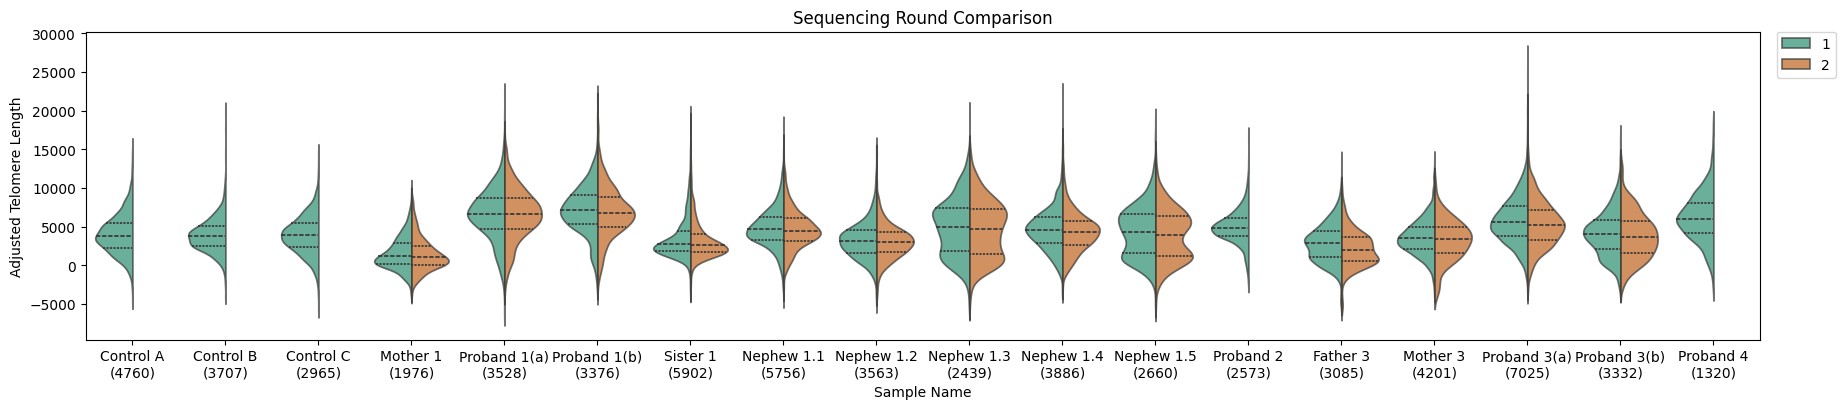

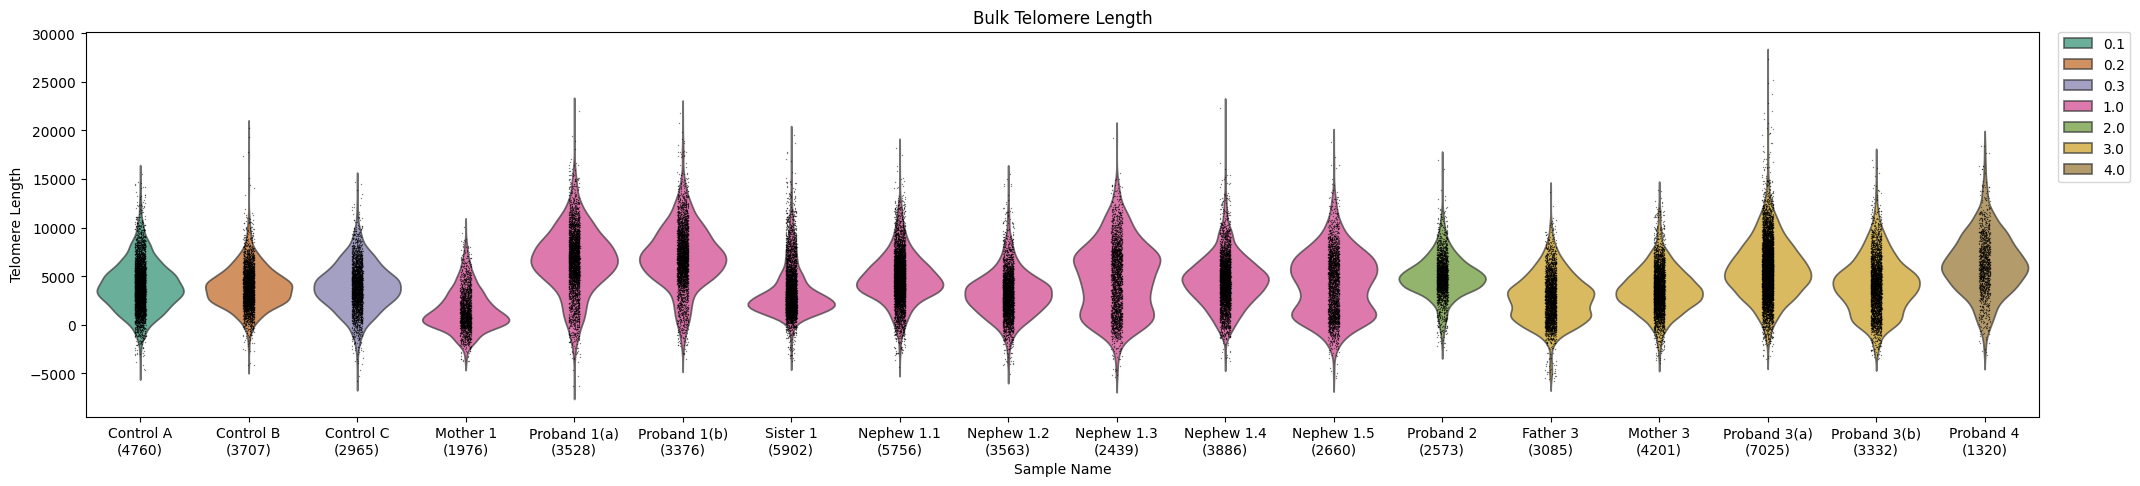

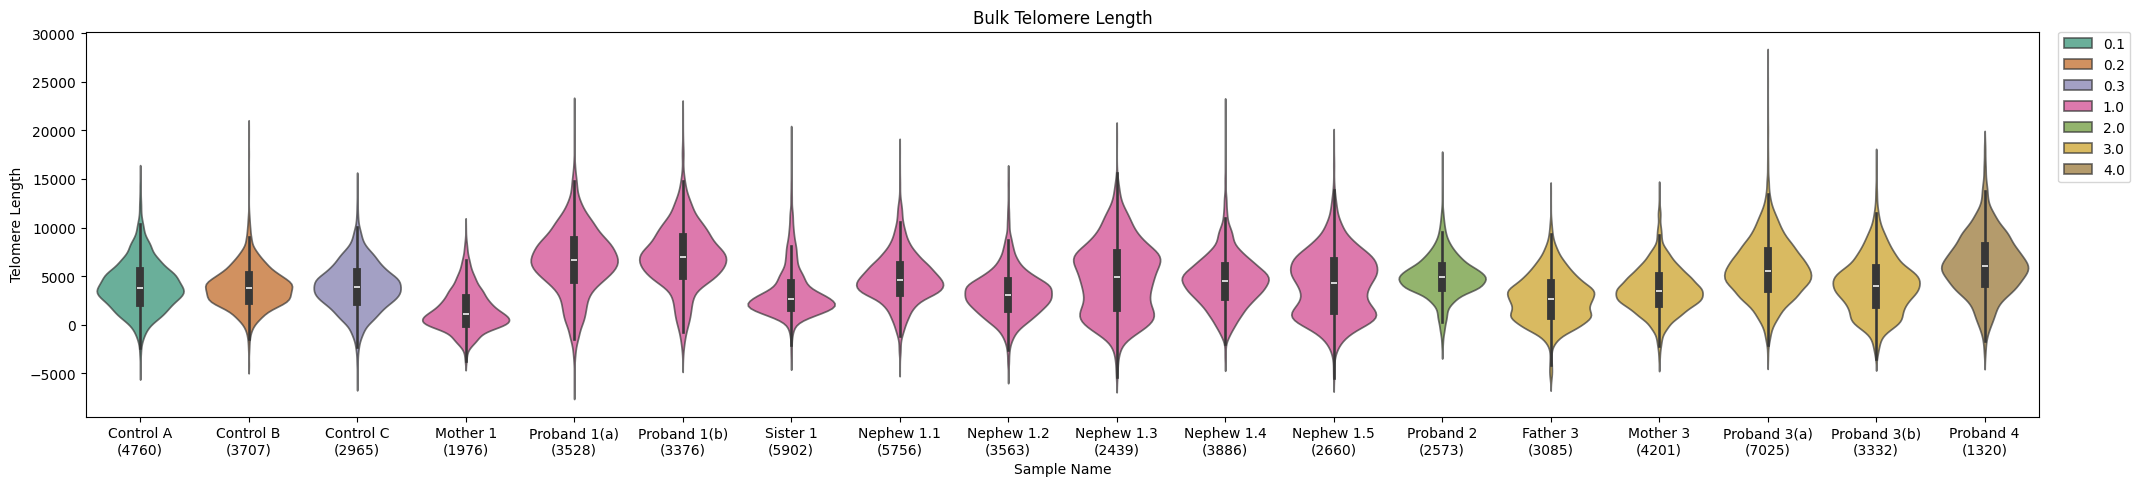

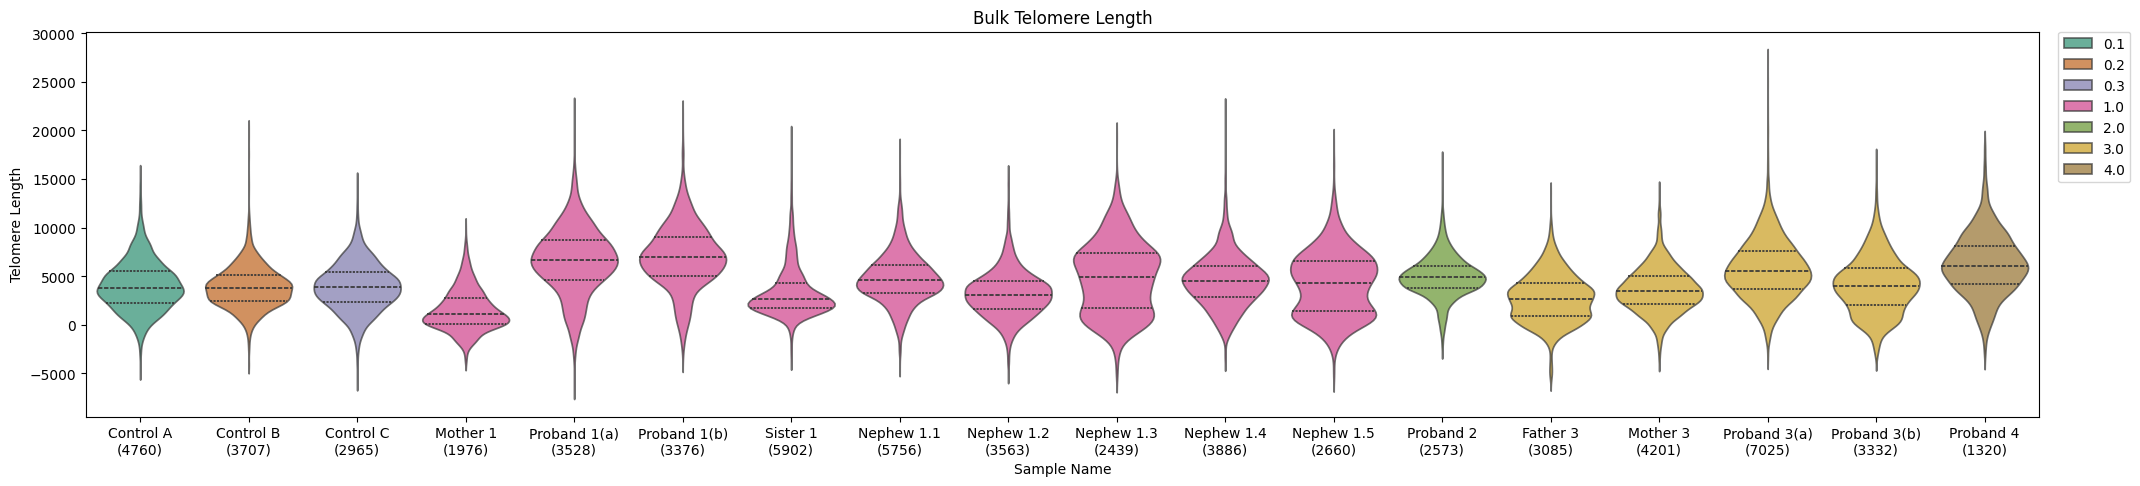

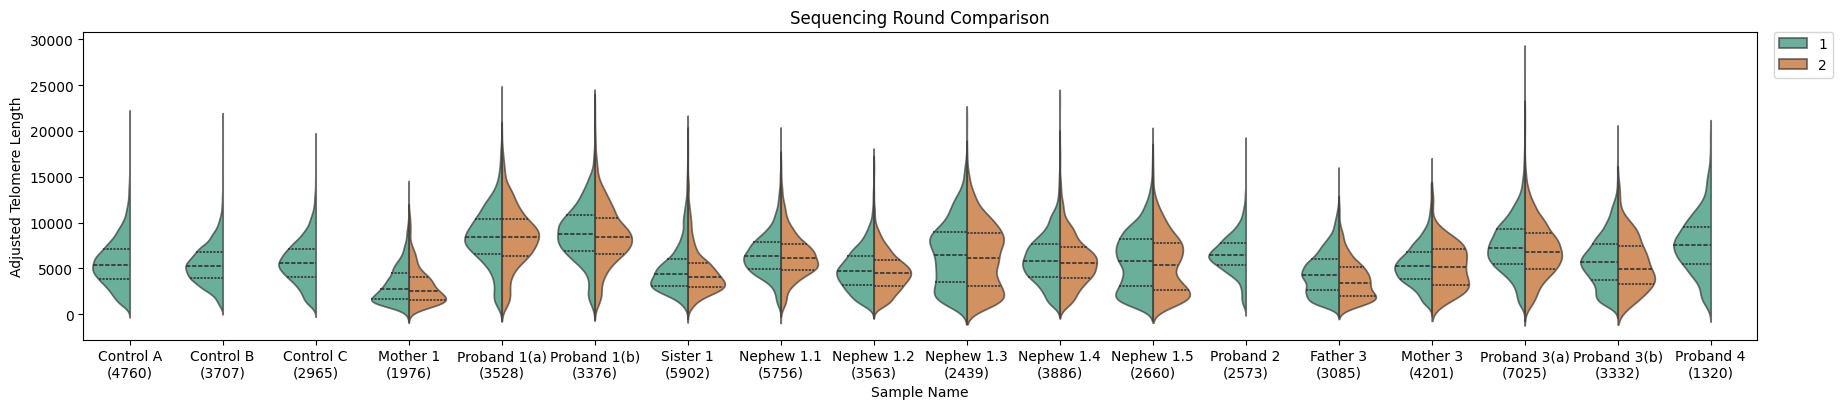

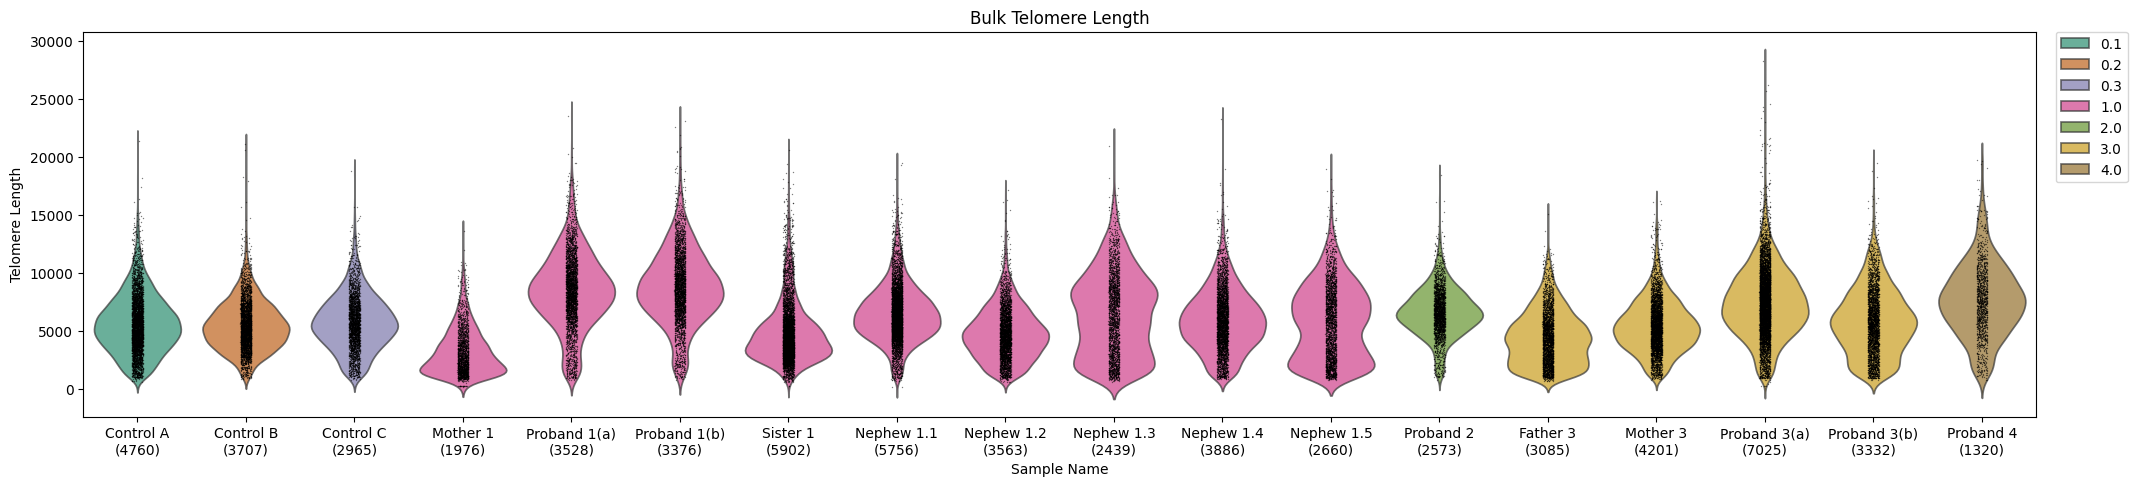

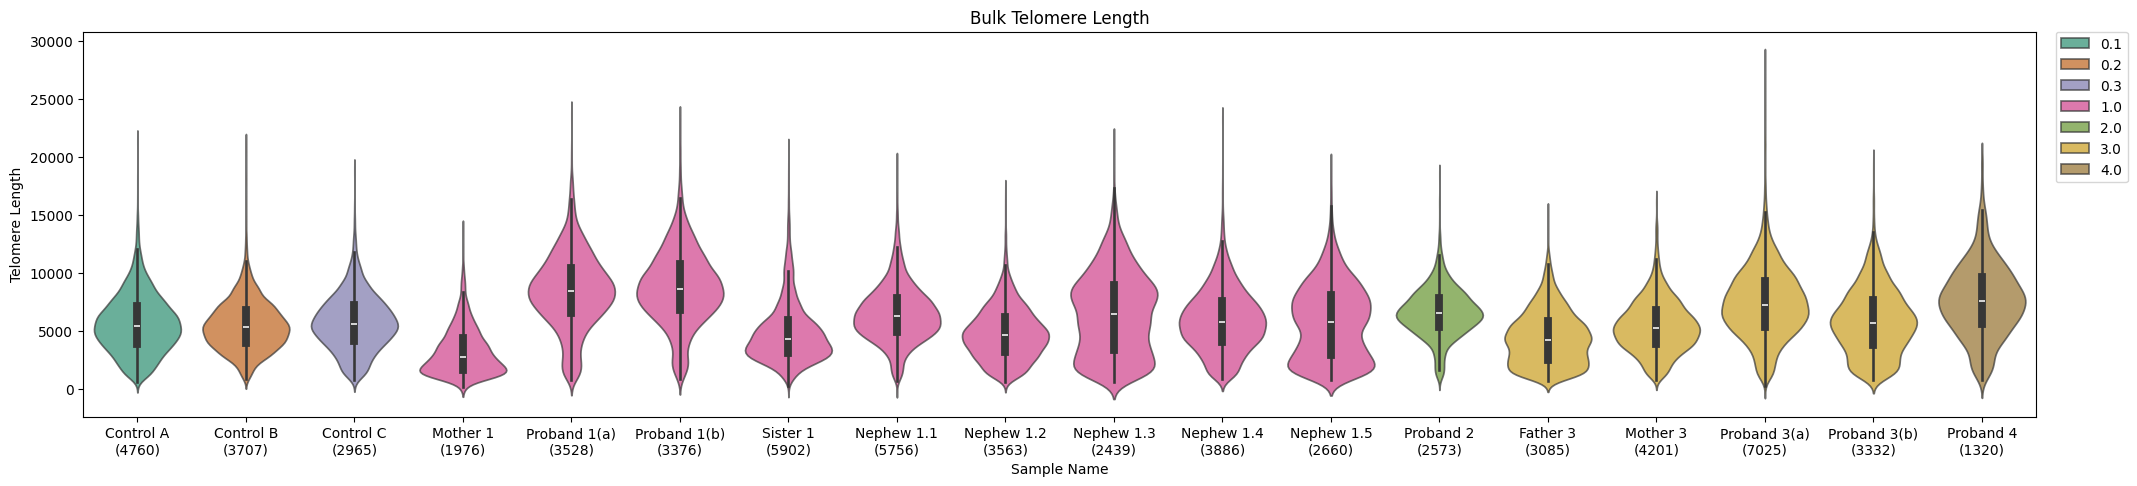

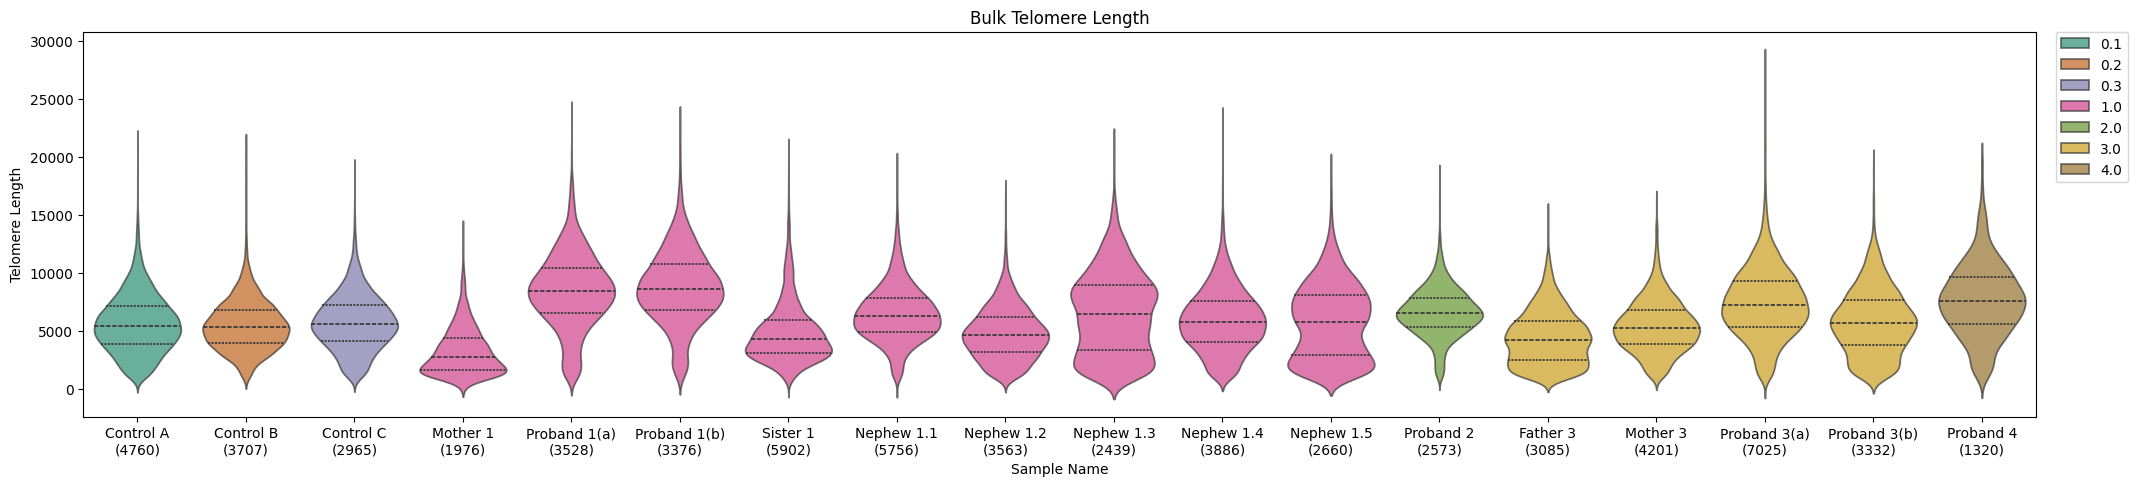

In [9]:
for measurement in ['tel_len','adj_tel_len']:
    unique_samples = unique(bulk_length_df['sample'].tolist())
    fig,ax = plt.subplots(figsize = (1.2*len(unique_samples),4))
    i = sns.violinplot(data=bulk_length_df,x='plot_name',y=measurement,hue='seq_round',split=True,
                    alpha=0.7,width=0.8,density_norm='width',inner='quart',palette='Dark2')
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    ax.set_title("Sequencing Round Comparison")
    ax.set_xlabel("Sample Name")
    ax.set_ylabel("Adjusted Telomere Length")
    prefix = f"seq_round_comparison_bulk_{measurement}"
    fig.savefig(os.path.join(figure_dir,prefix+'.png'),bbox_inches='tight')
    fig.savefig(os.path.join(figure_dir,prefix+'_Transparent.png'),bbox_inches='tight',transparent=True)
    svg_path = os.path.join(figure_dir,prefix+'.svg')
    ai_path = os.path.join(figure_dir,prefix+'.ai')
    plt.rcParams['svg.fonttype'] = 'none'
    # Save the heatmap as an SVG file
    fig.savefig(svg_path, format="svg",bbox_inches='tight')
    # Convert the SVG file to AI format
    cairosvg.svg2pdf(url=svg_path, write_to=ai_path)
    plt.show()
    plt.close()

    unique_samples = unique(bulk_length_df['sample'].tolist())
    fig,ax = plt.subplots(figsize = (1.4*len(unique_samples),5))
    i = sns.violinplot(data=bulk_length_df,x='plot_name',y=measurement,hue = "family", density_norm='width',
                    alpha=0.7,width=0.8,inner=None,palette='Dark2')
    j=sns.stripplot(data=bulk_length_df,x='plot_name',y=measurement,alpha=0.5,color='black',size=1,jitter=0.05)
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    ax.set_title("Bulk Telomere Length")
    ax.set_xlabel("Sample Name")
    ax.set_ylabel("Telomere Length")
    prefix = f"violin_plus_strip_bulk_{measurement}"
    fig.savefig(os.path.join(figure_dir,prefix+'.png'),bbox_inches='tight')
    fig.savefig(os.path.join(figure_dir,prefix+'_Transparent.png'),bbox_inches='tight',transparent=True)
    svg_path = os.path.join(figure_dir,prefix+'.svg')
    ai_path = os.path.join(figure_dir,prefix+'.ai')
    plt.rcParams['svg.fonttype'] = 'none'
    # Save the heatmap as an SVG file
    fig.savefig(svg_path, format="svg",bbox_inches='tight')
    # Convert the SVG file to AI format
    cairosvg.svg2pdf(url=svg_path, write_to=ai_path)
    plt.show()
    plt.close()

    unique_samples = unique(bulk_length_df['sample'].tolist())
    fig,ax = plt.subplots(figsize = (1.4*len(unique_samples),5))
    i = sns.violinplot(data=bulk_length_df,x='plot_name',y=measurement,hue = "family", density_norm='width',
                    alpha=0.7,width=0.8,palette='Dark2')
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    ax.set_title("Bulk Telomere Length")
    ax.set_xlabel("Sample Name")
    ax.set_ylabel("Telomere Length")
    prefix = f"violin_bulk_{measurement}"
    fig.savefig(os.path.join(figure_dir,prefix+'.png'),bbox_inches='tight')
    fig.savefig(os.path.join(figure_dir,prefix+'_Transparent.png'),bbox_inches='tight',transparent=True)
    svg_path = os.path.join(figure_dir,prefix+'.svg')
    ai_path = os.path.join(figure_dir,prefix+'.ai')
    plt.rcParams['svg.fonttype'] = 'none'
    # Save the heatmap as an SVG file
    fig.savefig(svg_path, format="svg",bbox_inches='tight')
    # Convert the SVG file to AI format
    cairosvg.svg2pdf(url=svg_path, write_to=ai_path)
    plt.show()
    plt.close()

    unique_samples = unique(bulk_length_df['sample'].tolist())
    fig,ax = plt.subplots(figsize = (1.4*len(unique_samples),5))
    i = sns.violinplot(data=bulk_length_df,x='plot_name',y=measurement,hue = "family", density_norm='width',
                    alpha=0.7,width=0.8,palette='Dark2',inner='quart')
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    ax.set_title("Bulk Telomere Length")
    ax.set_xlabel("Sample Name")
    ax.set_ylabel("Telomere Length")
    prefix = f"violin_bulk_quartile_{measurement}"
    fig.savefig(os.path.join(figure_dir,prefix+'.png'),bbox_inches='tight')
    fig.savefig(os.path.join(figure_dir,prefix+'_Transparent.png'),bbox_inches='tight',transparent=True)
    svg_path = os.path.join(figure_dir,prefix+'.svg')
    ai_path = os.path.join(figure_dir,prefix+'.ai')
    plt.rcParams['svg.fonttype'] = 'none'
    # Save the heatmap as an SVG file
    fig.savefig(svg_path, format="svg",bbox_inches='tight')
    # Convert the SVG file to AI format
    cairosvg.svg2pdf(url=svg_path, write_to=ai_path)
    plt.show()
    plt.close()